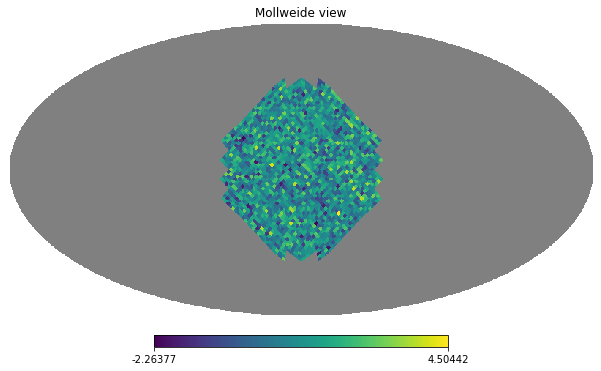

In [56]:
import tensorflow as tf
import numpy as np
import healpy as hp

from DeepSphere.utils import extend_indices
from DeepSphere import healpy_networks as hp_nn
from DeepSphere import gnn_layers
import matplotlib.pyplot as plt

NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

all_ipix = list(range(NPIX))
hp_map = np.zeros(NPIX)

# create a mask
pix = hp.query_disc(nside=NSIDE, vec=np.array([1.0, 0.0, 0.0]), radius=0.75)
hp_map[pix] = 1.0

hp_map_nest = hp.reorder(hp_map, r2n=True)
indices = np.arange(NPIX)[hp_map_nest > 0.5]

# With this first mask we might not be able to properly downsample to a wanted NSIDE
# so we extent the indices
indices_ext = extend_indices(indices=indices, nside_in=NSIDE, nside_out=8)

new_map = np.full(shape=(NPIX), fill_value=hp.UNSEEN)

for indice in indices_ext:
    new_map[indice] = np.random.normal(1)
for indice in indices:
    new_map[indice] = np.random.normal(1)

hp.mollview(new_map, nest=True)

new_map = np.expand_dims(new_map, axis=0)
new_map = np.expand_dims(new_map, axis=-1)

# Now we'll try to implement custom training:

In [57]:
layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
          gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='relu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

# build a model
tf.keras.backend.clear_session()
indices = np.arange(NPIX)
model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices, layers=layers)

model.build(input_shape=(1, len(indices), 1))

Detected a reduction factor of 4, the input with nside 32 will be reduced to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [58]:
# Define the loss and gradient function

# Again we will use the MeanAbsoluteError()
loss_object = tf.keras.losses.MeanAbsoluteError()


def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)

In [59]:
# Use the tf.GradientTape contex to calculate the gradients used
# to optimize the model.
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Setup the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.008)

In [60]:
# Build a training loop
# We want to generate the data on the fly.

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
global_norm_results = []

num_epochs = 120

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    epoch_global_norm = []
    
    # Training loop - use batches of 500
    # Generate the data on the fly
    for i in range(32):
        mean = np.random.rand()
        training_label = mean
        training_map = np.full(shape=(NPIX), fill_value=hp.UNSEEN)
        for indice in indices_ext:
            training_map[indice] = np.random.normal(loc=mean)
        for indice in indices:
            training_map[indice] = np.random.normal(loc=mean)
        training_map = np.expand_dims(training_map, axis=0)
        training_map = np.expand_dims(training_map, axis=-1)

        
        # Optimize the model
        loss_value, grads = grad(model, training_map, training_label)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value) # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(training_label, model(training_map, training=True))
        epoch_global_norm.append(tf.linalg.global_norm(grads))
        
    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    global_norm_results.append((sum(epoch_global_norm)/len(epoch_global_norm)))

        
    if epoch % 4 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 0.620
Epoch 004: Loss: 0.138
Epoch 008: Loss: 0.221
Epoch 012: Loss: 0.144
Epoch 016: Loss: 0.225
Epoch 020: Loss: 0.237
Epoch 024: Loss: 0.219
Epoch 028: Loss: 0.257
Epoch 032: Loss: 0.146
Epoch 036: Loss: 0.272
Epoch 040: Loss: 0.238
Epoch 044: Loss: 0.215
Epoch 048: Loss: 0.216
Epoch 052: Loss: 0.251
Epoch 056: Loss: 0.231
Epoch 060: Loss: 0.225
Epoch 064: Loss: 0.191
Epoch 068: Loss: 0.219
Epoch 072: Loss: 0.222
Epoch 076: Loss: 0.310
Epoch 080: Loss: 0.212
Epoch 084: Loss: 0.213
Ep

In [61]:
for i in range(10):
    mean = np.random.rand()
    label = mean
    data = np.full(shape=(NPIX), fill_value=hp.UNSEEN)
    for indice in indices:
        data[indice] = np.random.normal(loc=mean)
    for indice in indices_ext:
        data[indice] = np.random.normal(loc=mean)
    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=-1)
    predictions = model(data)
    print("Model predicted %f, true label is %s" % (predictions, mean))

Model predicted 0.503259, true label is 0.5792325811404233
Model predicted -0.132896, true label is 0.07162751971046111
Model predicted 0.297032, true label is 0.3245924869291994
Model predicted 0.507746, true label is 0.8838432273694332
Model predicted 0.105534, true label is 0.17122492388536303
Model predicted 0.507746, true label is 0.6293771669925692
Model predicted 0.507746, true label is 0.8294610472117798
Model predicted 0.336952, true label is 0.2811765112300372
Model predicted 0.524377, true label is 0.6758675968281896
Model predicted 0.370017, true label is 0.2910392904826078


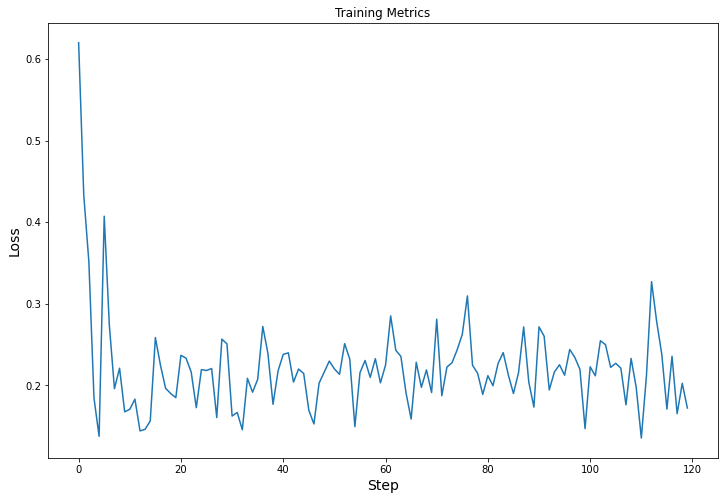

In [62]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)
plt.xlabel("Step", fontsize=14)
plt.show()


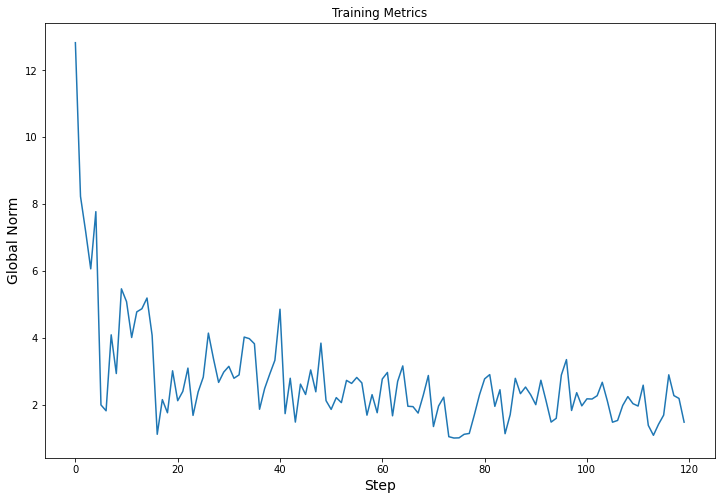

In [63]:
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Global Norm", fontsize=14)
plt.plot(global_norm_results)
plt.xlabel("Step", fontsize=14)
plt.show()
